# United States v. Shonubi (1997)

In [131]:
# packages

import pyro.ops.stats as stats
from pyro.infer import Predictive, SVI, Trace_ELBO, TracePredictive
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.nn import PyroSample, PyroModule
from pyro.optim import Adam
from torch import nn
import pyro.poutine as poutine


import os
from functools import partial
import torch
import inspect
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive


logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)

%matplotlib inline
plt.style.use('default')

In [19]:
# def run_svi_inference(
#     model,
#     num_steps=500,
#     verbose=True,
#     lr=0.03,
#     guide=None,
#     blocked_sites=None,
#     **model_kwargs,
# ):
#     losses = []
#     # running_loss_means = []
#     if guide is None:
#         guide = AutoMultivariateNormal(pyro.poutine.block(model, hide=blocked_sites))
#     elbo = pyro.infer.Trace_ELBO()(model, guide)

#     elbo(**model_kwargs)
#     adam = torch.optim.Adam(elbo.parameters(), lr=lr)
#     print(f"Running SVI for {num_steps} steps...")
#     for step in range(1, num_steps + 1):
#         adam.zero_grad()
#         loss = elbo(**model_kwargs)
#         loss.backward()
#         losses.append(loss.item())
#         adam.step()
#         if (step % 100 == 0) or (step == 1) & verbose:
#             print("[iteration %04d] loss: %.4f" % (step, loss))

#     plt.figure()
#     plt.plot(losses, label="ELBO loss")
#     sns.despine()
#     plt.title("ELBO Loss")
#     plt.ylim(0, max(losses))
#     plt.legend()
#     plt.show()

#     return guide
   



# def get_samples(
#     distance,
#     proximity,
#     how_far,
#     model= model_sigmavar_proximity,
#     num_svi_iters=num_svi_iters,
#     num_samples=num_samples,
# ):
#     guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
#     svi = SVI(
#         model_sigmavar_proximity, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO()
#     )

#     iterations = []
#     losses = []

#     logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
#     start_time = time.time()
#     pyro.clear_param_store()
#     for i in range(num_svi_iters):
#         elbo = svi.step(distance, proximity, how_far)
#         iterations.append(i)
#         losses.append(elbo)
#         if i % 50 == 0:
#             logging.info("Elbo loss: {}".format(elbo))
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

#     # uncomment if you want to see the ELBO loss plots
#     # fig = px.line(x=iterations, y=losses, title="ELBO loss", template="presentation")
#     # labels = {"iterations": "iteration", "losses": "loss"}
#     # fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
#     # fig.update_yaxes(showgrid=False, title_text=labels["losses"])
#     # fig.update_layout(width=700)
#     # fig.show()

#     predictive = Predictive(model, guide=guide, num_samples=num_samples)

#     proximity_svi = {
#         k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
#         for k, v in predictive(distance, proximity, how_far).items()
#         if k != "obs"
#     }

#     print("SVI-based coefficient marginals:")
#     for site, values in ft.summary(proximity_svi, ["d", "p"]).items():
#         print("Site: {}".format(site))
#         print(values, "\n")

#     return {
#         "svi_samples": proximity_svi,
#         "svi_guide": guide,
#         "svi_predictive": predictive,
#     }
    
    

In [243]:
def summary_sample(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "95%"]]
    return site_stats

def precis(samples):

    for site, values in summary_sample(samples).items():
        print("Site: {}".format(site))
        print(values, "\n") 

In [4]:
# the dataset

sh = pd.read_csv('ShonubiCaseDataset.csv')
sh.head(5)

,obs,dataset,balloons,gross_wt,net_wt,purity,age_yrs,gender
0,1.0,1.0,79.0,742.4,503.2,0.51,NaN,NaN
1,2.0,1.0,90.0,901.7,576.9,0.32,NaN,NaN
2,3.0,12.0,90.0,800.2,573.3,0.85,38.0,1.0
3,4.0,12.0,1.0,706.2,439.8,0.75,41.0,1.0
4,5.0,1.0,5.0,72.2,23.1,0.62,NaN,NaN


FIRST, STRATEGY WHICH USES POSTERIOR MEANS ONLY


note there are 107 cases with gross_wt, but no net_wt. Let's first predict
those, then fill them in to predict weight based on balloons

In [215]:
compData = sh[['gross_wt', 'net_wt']].dropna()

data_gross = torch.tensor(compData[["gross_wt", "net_wt"]].values,
                        dtype=torch.float)

gross_wt, net_wt  = data_gross[:, 0], data_gross[:, 1]
    
    
def model_net1(gross_wt, net_wt = None):
    b_a = pyro.sample("bA", dist.Normal(0.6, 0.3))
    sigma = pyro.sample("sigma", dist.Uniform(0., 150.))
    mean = b_a * gross_wt
    with pyro.plate("data_gross", len(gross_wt)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=net_wt)
        
        

In [216]:
guide_net1 = AutoDiagonalNormal(model_net1)
adam = pyro.optim.Adam({"lr": 0.03})

svi__net1 = SVI(model_net1, guide_net1, adam, loss=Trace_ELBO())




In [217]:
num_iterations = 1500 if not smoke_test else 2

for i in range(num_iterations):
    elbo = svi__net1.step(gross_wt, net_wt)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 776.0221927165985


Elbo loss: 775.748527765274
Elbo loss: 775.8560025691986


In [224]:
num_samples = 1000
predictive = Predictive(model_net1, guide=guide_net1, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(gross_wt, net_wt).items()
               if k != "obs"}

In [244]:
precis(svi_samples)

Site: bA
       mean       std        5%       95%
0  0.608527  0.010248  0.591767  0.625756 

Site: sigma
         mean       std          5%         95%
0  124.464325  7.702669  110.192801  135.431781 



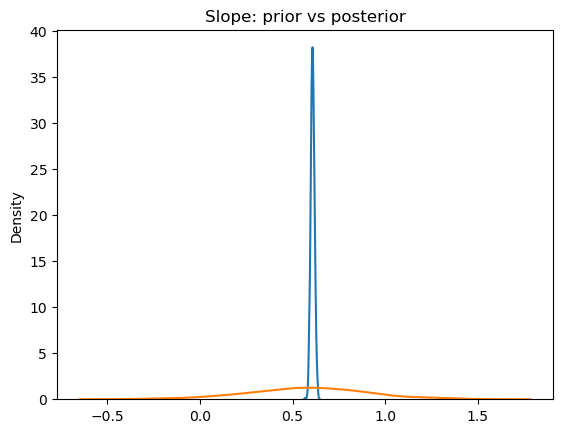

In [227]:
# density plot of a slope

prior_bA = pyro.sample("bA", dist.Normal(0.6, 0.3).expand([500]))

sns.kdeplot(svi_samples['bA'], fill=False)
sns.kdeplot(prior_bA, fill=False)
plt.title('Slope: prior vs posterior')
plt.show()

In [155]:
predictive = Predictive(model_net1, guide=guide_net1, num_samples=num_samples)
samples1 = predictive(gross_wt)
samples1.keys()

dict_keys(['bA', 'sigma', 'obs'])

In [184]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

pred_summary = summary(samples1)

In [148]:
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "gross_wt": gross_wt,
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "net_wt": net_wt,
})

predictions

,gross_wt,y_mean,y_perc_5,y_perc_95,net_wt
0,742.400024,444.044556,241.792496,653.321655,503.200012
1,901.700012,546.299194,339.136017,752.889038,576.900024
2,800.200012,481.105713,277.595673,690.190613,573.299988
3,706.200012,424.871490,213.083755,637.824097,439.799988
4,72.199997,47.430695,-171.579620,246.944656,23.100000
...,...,...,...,...,...
119,906.400024,552.223267,338.825684,764.747803,462.299988
120,1222.000000,731.734436,522.250244,939.612305,836.700012
121,1108.900024,666.439697,464.261658,875.929260,582.000000
122,886.299988,525.049194,312.502747,735.635010,467.299988


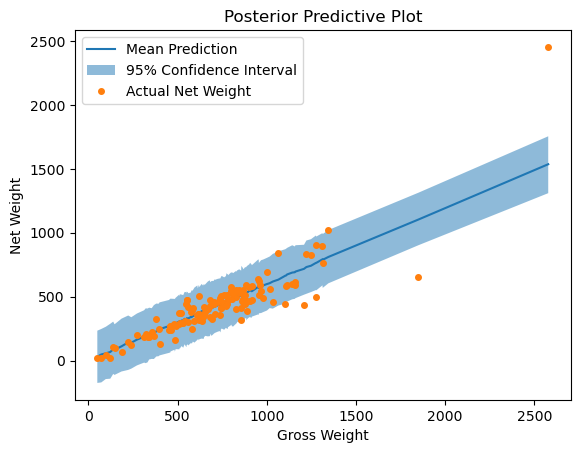

In [230]:

predictions = predictions.sort_values(by=["gross_wt"])

plt.plot(predictions["gross_wt"], predictions["y_mean"], label='Mean Prediction')
plt.fill_between(predictions['gross_wt'],
                  predictions["y_perc_5"],
                    predictions["y_perc_95"], alpha=0.5, label='95% Confidence Interval')
plt.plot(predictions["gross_wt"], predictions["net_wt"], "o",
          markersize=4, label='Actual Net Weight')

plt.title('Posterior Predictive Plot')
plt.xlabel('Gross Weight')
plt.ylabel('Net Weight')
plt.legend()

plt.show()


## Filling missing net values

In [ ]:
# taking a subset of missing net_wt values

fillNet = sh.copy()[(~sh['gross_wt'].isna()) & (sh['net_wt'].isna())]
gross_wtFILL = torch.tensor(fillNet["gross_wt"].values, dtype=torch.float)

samples_FILL = predictive(gross_wtFILL)

samples_preds = samples_FILL['obs']
samples_preds_summ = summary(samples_FILL)['obs']


Summary of predictions for missing net weights:

In [194]:
predictions_df = pd.DataFrame({
    "gross_wt": gross_wtFILL,
    "y_mean": samples_preds_summ["mean"],
    "y_perc_5": samples_preds_summ["5%"],
    "y_perc_95": samples_preds_summ["95%"],
})

predictions_df

,gross_wt,y_mean,y_perc_5,y_perc_95
0,331.0,198.097137,-7.232910,397.222961
1,572.0,343.033875,131.835617,546.396240
2,698.0,418.577301,201.821243,617.440186
3,594.0,359.885315,150.782150,571.811523
4,204.0,117.670326,-99.160622,329.438904
...,...,...,...,...
72,876.0,519.623047,304.053680,724.357666
73,855.0,510.722992,300.945801,715.211548
74,795.0,477.846069,276.255676,695.052368
75,323.0,190.556625,-8.738327,410.288940


Adding columns with estimates of net weights

In [237]:
merged_df = pd.merge(sh, predictions_df, on='gross_wt', how='left')
merged_df['netestimate_mean'] = merged_df['net_wt'].fillna(merged_df['y_mean'])
merged_df['netestimate_low'] = merged_df['net_wt'].fillna(merged_df['y_perc_5'])
sh_est = merged_df.drop(['y_mean', 'y_perc_5', 'y_perc_95'], axis=1)

sh_est

,obs,dataset,balloons,gross_wt,net_wt,purity,age_yrs,gender,netestimate_mean,netestimate_low
0,1.0,1.0,79.0,742.4,503.2,0.51,NaN,NaN,503.2,503.2
1,2.0,1.0,90.0,901.7,576.9,0.32,NaN,NaN,576.9,576.9
2,3.0,12.0,90.0,800.2,573.3,0.85,38.0,1.0,573.3,573.3
3,4.0,12.0,1.0,706.2,439.8,0.75,41.0,1.0,439.8,439.8
4,5.0,1.0,5.0,72.2,23.1,0.62,NaN,NaN,23.1,23.1
...,...,...,...,...,...,...,...,...,...,...
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
